In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import h5py

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Input, Dropout, Flatten, Conv2D,MaxPool2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import utils
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pydot
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [258]:
tf.__version__

'2.9.1'

In [440]:
hdf5_x_file = 'dataset/camelyonpatch_x.h5'
hdf5_y_file = 'dataset/camelyonpatch_y.h5'

hfx = h5py.File(hdf5_x_file, 'r')
hfy = h5py.File(hdf5_y_file, 'r')

X = hfx['x']
y = hfy['y']

print("X shape = ",X.shape)
print("y shape = ",y.shape)

X shape =  (32768, 96, 96, 3)
y shape =  (32768, 1, 1, 1)


### Konvertovanje u np.array

In [441]:
X = np.array(X)[:12000]
y = np.array(y)[:12000]

### Reshape iz  4D u 2D

In [261]:
nsamples, nx, ny, nrgb = X.shape
X_reshape = X.reshape((nsamples,nx*ny*nrgb))
print('2D X shape = ',X_reshape.shape)

y_reshape = y.ravel()
print('2D y shape = ',y_reshape.shape)

2D X shape =  (12000, 27648)
2D y shape =  (12000,)


In [63]:
print(X_reshape)

[[247 246 244 ... 243 241 244]
 [216 166 203 ... 227 213 226]
 [184 155 186 ... 251 205 242]
 ...
 [111  89 189 ... 106 106 142]
 [175 131 218 ... 174  94 183]
 [178 138 227 ...  15  39 101]]


In [64]:
print(y_reshape)

[0 1 0 ... 1 1 1]


In [262]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X_reshape, y_reshape, test_size = 0.4, random_state = 42, stratify = y_reshape )
X_test, X_validation, y_test, y_validation = train_test_split(X_test_and_val, y_test_and_val, train_size = 0.5, random_state = 42, stratify = y_test_and_val)

In [263]:
del X_reshape, y_reshape

In [264]:
X_train.shape

(7200, 27648)

In [265]:
X_test.shape

(2400, 27648)

In [266]:
X_validation.shape

(2400, 27648)

In [70]:
print(X_train)

[[ 55  29  40 ...  66  19  71]
 [ 69  32  66 ... 166 128 175]
 [201 206 212 ... 224  97 212]
 ...
 [201 157 192 ... 255 217 239]
 [ 40  23  57 ... 231 169 206]
 [228 222 236 ... 226 215 231]]


In [71]:
print(y_train)

[0 0 1 ... 0 1 0]


In [72]:
print(X_test)

[[142  95 129 ... 202 130 152]
 [148 126 173 ... 159 111 153]
 [233 226 234 ... 229 222 230]
 ...
 [208 117 150 ... 234 239 233]
 [244 207 225 ... 246 246 244]
 [ 82  22  84 ... 107  58 103]]


In [73]:
print(y_test)

[1 0 0 ... 0 0 0]


In [74]:
print(X_validation)

[[218 228 227 ... 110  85 186]
 [244 233 231 ... 236 205 211]
 [175 128 146 ... 207 184 194]
 ...
 [147  77 175 ... 108  44 158]
 [153  96 128 ... 201 130 164]
 [252 246 255 ...  52  30  76]]


In [75]:
print(y_validation)

[1 1 1 ... 0 1 0]


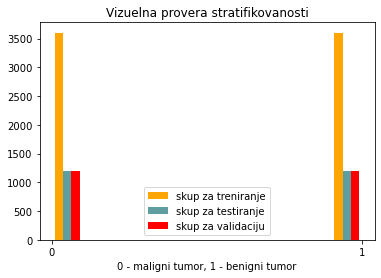

In [267]:
plt.title('Vizuelna provera stratifikovanosti')
plt.xticks([0,1])
plt.xlabel('0 - maligni tumor, 1 - benigni tumor')
plt.hist([y_train, y_test, y_validation], color=['orange', 'cadetblue', 'red'], label=['skup za treniranje', 'skup za testiranje','skup za validaciju'])
plt.legend(loc='best')
plt.show()

### Standardizacija

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

In [21]:
print(X_train)

[[-1.88647399 -1.44093522 -2.593453   ... -1.744461   -1.58952023
  -2.00642359]
 [-1.66148322 -1.39940955 -2.09924623 ... -0.14662173 -0.10030922
  -0.06609754]
 [ 0.45985838  1.00907972  0.67591488 ...  0.78012505 -0.52384629
   0.62421077]
 ...
 [ 0.45985838  0.33082699  0.29575583 ...  1.27545522  1.11565207
   1.12794926]
 [-2.12753554 -1.52398658 -2.2703178  ...  0.8919738   0.45985272
   0.51226888]
 [ 0.89376916  1.23055     1.13210575 ...  0.81208184  1.0883271
   0.97869341]]


In [22]:
print(X_test)

[[-0.48831703 -0.52737033 -0.9017452  ...  0.42860041 -0.07298424
  -0.49520811]
 [-0.39189241 -0.09827167 -0.06539528 ... -0.25847047 -0.33257148
  -0.47655113]
 [ 0.97412301  1.28591757  1.09408984 ...  0.86001701  1.1839645
   0.96003643]
 ...
 [ 0.57235376 -0.2228487  -0.50257819 ...  0.93990898  1.41622677
   1.01600737]
 [ 1.15090147  1.02292161  0.92301827 ...  1.13164969  1.51186417
   1.22123417]
 [-1.45256321 -1.53782847 -1.75710308 ... -1.08934689 -1.05668326
  -1.40940019]]


In [23]:
print(X_validation)

[[ 0.73306146  1.31360135  0.96103417 ... -1.04141172 -0.68779613
   0.13912925]
 [ 1.15090147  1.38281081  1.03706599 ...  0.97186576  0.95170223
   0.60555379]
 [ 0.04201837 -0.07058788 -0.57861    ...  0.50849237  0.66479002
   0.2883851 ]
 ...
 [-0.40796318 -0.77652439 -0.02737937 ... -1.0733685  -1.24795807
  -0.38326622]
 [-0.31153857 -0.51352844 -0.92075315 ...  0.41262202 -0.07298424
  -0.27132433]
 [ 1.27946763  1.56275541  1.49325685 ... -1.96815849 -1.43923288
  -1.91313868]]


# 1.Neuronska mreža

### Kreiranje mreže

In [268]:
ann = Sequential()

In [269]:
ann.add(InputLayer(input_shape=(nx*ny*nrgb,)))
ann.add(Dense(units=nx*ny, activation='relu'))
ann.add(Dense(units=nx, activation='relu'))
ann.add(Dense(units=1, activation='sigmoid'))

In [270]:
ann.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 9216)              254813184 
                                                                 
 dense_18 (Dense)            (None, 96)                884832    
                                                                 
 dense_19 (Dense)            (None, 1)                 97        
                                                                 
Total params: 255,698,113
Trainable params: 255,698,113
Non-trainable params: 0
_________________________________________________________________


### Treniranje mreže

In [271]:
ann.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

In [28]:
history = ann.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=128,
                  validation_data=(X_validation, y_validation))

Epoch 1/50
57/57 [==============================] - 168s 3s/step - loss: 17.8633 - accuracy: 0.5487 - val_loss: 0.6959 - val_accuracy: 0.5325
Epoch 2/50
57/57 [==============================] - 149s 3s/step - loss: 0.6753 - accuracy: 0.5331 - val_loss: 0.7053 - val_accuracy: 0.5350
Epoch 3/50
57/57 [==============================] - 150s 3s/step - loss: 0.6704 - accuracy: 0.5474 - val_loss: 0.6963 - val_accuracy: 0.5400
Epoch 4/50
57/57 [==============================] - 142s 2s/step - loss: 0.6410 - accuracy: 0.6193 - val_loss: 0.7804 - val_accuracy: 0.6558
Epoch 5/50
57/57 [==============================] - 143s 3s/step - loss: 0.6117 - accuracy: 0.6515 - val_loss: 0.7349 - val_accuracy: 0.5896
Epoch 6/50
57/57 [==============================] - 137s 2s/step - loss: 0.6002 - accuracy: 0.6571 - val_loss: 0.8045 - val_accuracy: 0.6500
Epoch 7/50
57/57 [==============================] - 141s 2s/step - loss: 0.5731 - accuracy: 0.6847 - val_loss: 0.7358 - val_accuracy: 0.6417
Epoch 8/50
5

### Ocena neuronske mreže

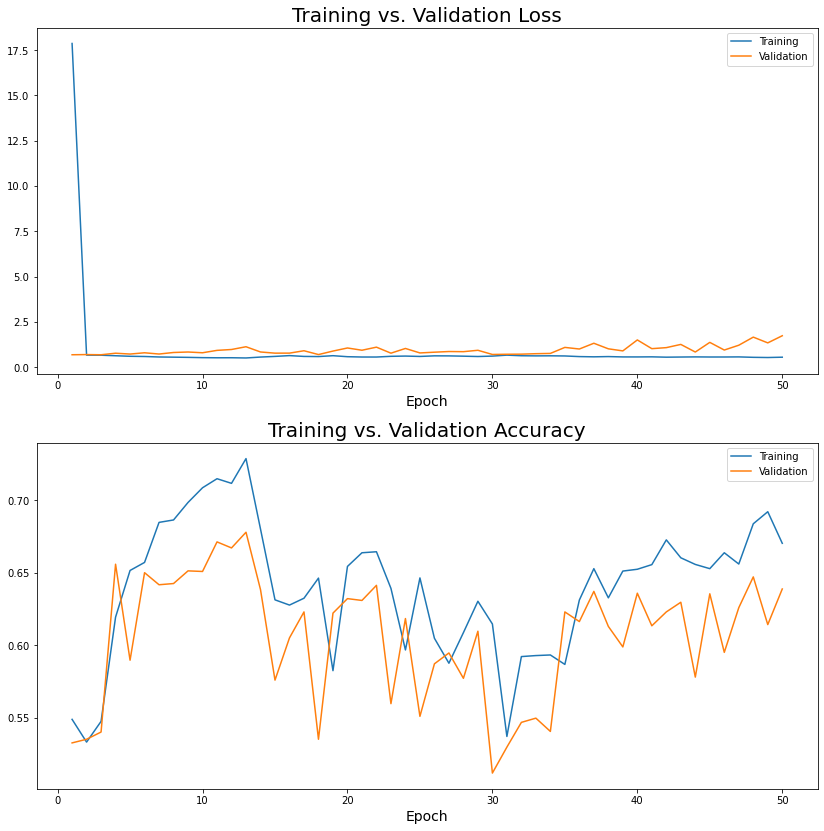

In [83]:
plt.figure(figsize=(14,14))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history.history['val_loss'], label='Validation')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history.history['val_accuracy'], label='Validation')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()

### Evaluacija

In [126]:
train_scores = ann.evaluate(X_train, y_train, batch_size=128)
print('\nTraining set {0}: {1}'.format(ann.metrics_names[1], train_scores[1]))
print('\nTraining set {0}: {1}'.format(ann.metrics_names[0], train_scores[0]))

57/57 [==============================] - 41s 715ms/step - loss: 0.5505 - accuracy: 0.6749

Training set accuracy: 0.6748611330986023

Training set loss: 0.5505223870277405


In [127]:
test_scores = ann.evaluate(X_test, y_test, batch_size=128)
print('\nTest set {0}: {1}'.format(ann.metrics_names[1], test_scores[1]))
print('\nTest set {0}: {1}'.format(ann.metrics_names[0], test_scores[0]))

19/19 [==============================] - 14s 731ms/step - loss: 1.4409 - accuracy: 0.6233

Test set accuracy: 0.6233333349227905

Test set loss: 1.4408799409866333


# 2. Konvolutivna neuronska mreža

In [465]:
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X shape =  (12000, 96, 96, 3)
y shape =  (12000, 1, 1, 1)


### Podela ulaza na Train, Test i Validation

In [466]:
split_1 = int(0.6 * X.shape[0])
split_2 = int(0.8 * X.shape[0])

X_trainc = X[:split_1]
X_validationc = X[split_1:split_2]
X_testc = X[split_2:]

y_trainc = y[:split_1]
y_validationc = y[split_1:split_2]
y_testc = y[split_2:]

In [467]:
print("X_trainc shape = ",X_trainc.shape)
print("y_trainc shape = {} \n".format(y_trainc.shape))

print("X_validationc shape = ",X_validationc.shape)
print("y_validationc shape = {} \n".format(y_validationc.shape))

print("X_testc shape = ",X_testc.shape)
print("y_testc shape = ",y_testc.shape)

X_trainc shape =  (7200, 96, 96, 3)
y_trainc shape = (7200, 1, 1, 1) 

X_validationc shape =  (2400, 96, 96, 3)
y_validationc shape = (2400, 1, 1, 1) 

X_testc shape =  (2400, 96, 96, 3)
y_testc shape =  (2400, 1, 1, 1)


### Normalizacija

In [468]:
X_trainc = X_trainc / 255
X_validationc = X_validationc / 255
X_testc = X_testc / 255

In [469]:
y_trainc = y_trainc.ravel()
y_validationc = y_validationc.ravel()
y_testc = y_testc.ravel()

In [470]:
print(X_trainc)

[[[[0.96862745 0.96470588 0.95686275]
   [0.96470588 0.96078431 0.95294118]
   [0.96470588 0.96078431 0.95294118]
   ...
   [0.92156863 0.9254902  0.90196078]
   [0.98431373 0.98039216 0.97254902]
   [0.99607843 0.99607843 0.99607843]]

  [[0.96862745 0.96470588 0.95686275]
   [0.96470588 0.96078431 0.95294118]
   [0.96470588 0.96078431 0.95294118]
   ...
   [0.96862745 0.96470588 0.95686275]
   [0.96078431 0.95294118 0.95686275]
   [0.96078431 0.96078431 0.96862745]]

  [[0.96862745 0.96470588 0.95686275]
   [0.96470588 0.96078431 0.95294118]
   [0.96470588 0.96078431 0.95294118]
   ...
   [1.         0.99607843 1.        ]
   [0.95294118 0.94509804 0.95686275]
   [0.9254902  0.92156863 0.94117647]]

  ...

  [[0.95686275 0.95686275 0.94901961]
   [0.95686275 0.95686275 0.94901961]
   [0.95686275 0.95686275 0.94901961]
   ...
   [0.95686275 0.94901961 0.95294118]
   [0.96078431 0.95294118 0.95686275]
   [0.97647059 0.96078431 0.96470588]]

  [[0.95294118 0.95294118 0.94509804]
   [0.9

In [471]:
print(X_validationc)

[[[[0.39215686 0.18823529 0.62352941]
   [0.41176471 0.18431373 0.61568627]
   [0.34509804 0.08627451 0.50196078]
   ...
   [0.88627451 0.84313725 0.89803922]
   [0.88627451 0.84313725 0.89803922]
   [0.88627451 0.84313725 0.89803922]]

  [[0.37254902 0.1372549  0.58039216]
   [0.36862745 0.11764706 0.54901961]
   [0.40784314 0.1372549  0.55294118]
   ...
   [0.88627451 0.84313725 0.89803922]
   [0.88627451 0.84313725 0.89803922]
   [0.88627451 0.84313725 0.89803922]]

  [[0.41568627 0.13333333 0.56470588]
   [0.39607843 0.11372549 0.5372549 ]
   [0.60784314 0.32156863 0.73333333]
   ...
   [0.89019608 0.84705882 0.90196078]
   [0.88627451 0.84313725 0.89803922]
   [0.88627451 0.84313725 0.89803922]]

  ...

  [[0.70588235 0.57254902 0.8627451 ]
   [0.43529412 0.26666667 0.58823529]
   [0.54901961 0.31372549 0.69019608]
   ...
   [0.87843137 0.83137255 0.88627451]
   [0.87843137 0.83137255 0.88627451]
   [0.88235294 0.83529412 0.89019608]]

  [[0.70980392 0.56470588 0.86666667]
   [0.5

In [472]:
print(X_testc)

[[[[0.71372549 0.51764706 0.66666667]
   [0.57254902 0.35686275 0.50980392]
   [0.57254902 0.3372549  0.48627451]
   ...
   [0.7372549  0.47058824 0.62352941]
   [0.77254902 0.49411765 0.65098039]
   [0.7254902  0.44705882 0.61176471]]

  [[0.70588235 0.51764706 0.68235294]
   [0.6        0.39215686 0.55686275]
   [0.64705882 0.40784314 0.56862745]
   ...
   [0.65882353 0.40392157 0.56078431]
   [0.67058824 0.41568627 0.57254902]
   [0.61568627 0.35294118 0.51372549]]

  [[0.6627451  0.4745098  0.67058824]
   [0.55294118 0.34117647 0.53333333]
   [0.62352941 0.38039216 0.54117647]
   ...
   [0.57647059 0.35294118 0.51372549]
   [0.61176471 0.37254902 0.53333333]
   [0.57254902 0.3372549  0.48627451]]

  ...

  [[0.78823529 0.49803922 0.63529412]
   [0.81568627 0.54509804 0.66666667]
   [0.85882353 0.6        0.70588235]
   ...
   [0.89803922 0.65490196 0.7372549 ]
   [0.84705882 0.60392157 0.69411765]
   [0.83529412 0.59215686 0.68235294]]

  [[0.81568627 0.52156863 0.65098039]
   [0.8

In [473]:
print("X_trainc shape = ",X_trainc.shape)
print("y_trainc shape = {} \n".format(y_trainc.shape))

print("X_validationc shape = ",X_validationc.shape)
print("y_validationc shape = {} \n".format(y_validationc.shape))

print("X_testc shape = ",X_testc.shape)
print("y_testc shape = ",y_testc.shape)

X_trainc shape =  (7200, 96, 96, 3)
y_trainc shape = (7200,) 

X_validationc shape =  (2400, 96, 96, 3)
y_validationc shape = (2400,) 

X_testc shape =  (2400, 96, 96, 3)
y_testc shape =  (2400,)


### Kreiranje konvolutivne mreže

#### Inicijalizacija

In [483]:
cnn = Sequential()

#### Konvolucija

In [484]:
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[96, 96, 3]))

#### Agregacija - Max Pooling

In [485]:
cnn.add(MaxPool2D(pool_size=2, strides=2))

In [486]:
#Dodavanje drugog konvolutivnog sloja

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPool2D(pool_size=2, strides=2))

#### Ispravljanje - Flattening

In [487]:
cnn.add(Flatten())

#### Povezivanje

In [488]:
cnn.add(Dense(units=1000, activation='relu'))
cnn.add(Dense(units=1, activation='sigmoid'))

### Sumacija postavke konvolutivne mreže

In [489]:
cnn.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 flatten_26 (Flatten)        (None, 15488)             0         
                                                                 
 dense_57 (Dense)            (None, 1000)            

### Treniranje konvolucione mreže

In [490]:
cnn.compile(optimizer = 'adam', 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy'])

In [491]:
history_cnn = cnn.fit(x = X_trainc, 
                      y = y_trainc, 
                      validation_data = (X_validationc, y_validationc), 
                      epochs = 20)

Epoch 1/20
225/225 [==============================] - 79s 348ms/step - loss: 0.6576 - accuracy: 0.6703 - val_loss: 0.5295 - val_accuracy: 0.7679
Epoch 2/20
225/225 [==============================] - 63s 279ms/step - loss: 0.4981 - accuracy: 0.7647 - val_loss: 0.4685 - val_accuracy: 0.7788
Epoch 3/20
225/225 [==============================] - 64s 283ms/step - loss: 0.4002 - accuracy: 0.8251 - val_loss: 0.4717 - val_accuracy: 0.7783
Epoch 4/20
225/225 [==============================] - 67s 296ms/step - loss: 0.2898 - accuracy: 0.8821 - val_loss: 0.5095 - val_accuracy: 0.7754
Epoch 5/20
225/225 [==============================] - 72s 320ms/step - loss: 0.1818 - accuracy: 0.9315 - val_loss: 0.6818 - val_accuracy: 0.7646
Epoch 6/20
225/225 [==============================] - 65s 287ms/step - loss: 0.0736 - accuracy: 0.9772 - val_loss: 0.8758 - val_accuracy: 0.7604
Epoch 7/20
225/225 [==============================] - 62s 276ms/step - loss: 0.0211 - accuracy: 0.9962 - val_loss: 0.8977 - val_ac

### Evaluacija konvolucione mreže

In [492]:
train_scores_cnn = cnn.evaluate(X_trainc, y_trainc, batch_size=128)
print('Training set {0}: {1}'.format(cnn.metrics_names[1], train_scores_cnn[1]))
print('Training set {0}: {1}'.format(cnn.metrics_names[0], train_scores_cnn[0]))

57/57 [==============================] - 12s 209ms/step - loss: 4.7636e-05 - accuracy: 1.0000
Training set accuracy: 1.0
Training set loss: 4.7635599912609905e-05


In [493]:
test_scores_cnn = cnn.evaluate(X_testc, y_testc, batch_size=128)
print('Test set {0}: {1}'.format(cnn.metrics_names[1], test_scores_cnn[1]))
print('Test set {0}: {1}'.format(cnn.metrics_names[0], test_scores_cnn[0]))

19/19 [==============================] - 4s 210ms/step - loss: 1.7469 - accuracy: 0.7817
Test set accuracy: 0.7816666960716248
Test set loss: 1.746937870979309


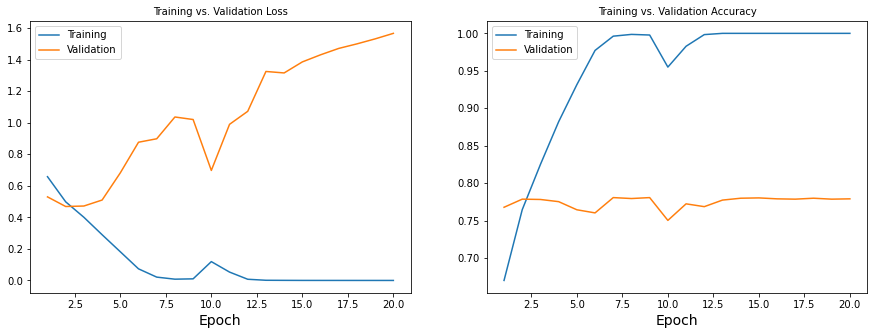

In [494]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)

plt.plot(np.arange(1, 21), history_cnn.history['loss'], label='Training')
plt.plot(np.arange(1, 21), history_cnn.history['val_loss'], label='Validation')
plt.title('Training vs. Validation Loss', size=10)
plt.xlabel('Epoch', size=14)
plt.legend()


plt.subplot(1, 2, 2)

plt.plot(np.arange(1, 21), history_cnn.history['accuracy'], label='Training')
plt.plot(np.arange(1, 21), history_cnn.history['val_accuracy'], label='Validation')
plt.title('Training vs. Validation Accuracy', size=10)
plt.xlabel('Epoch', size=14)
plt.legend()

plt.show()

# Zaključak

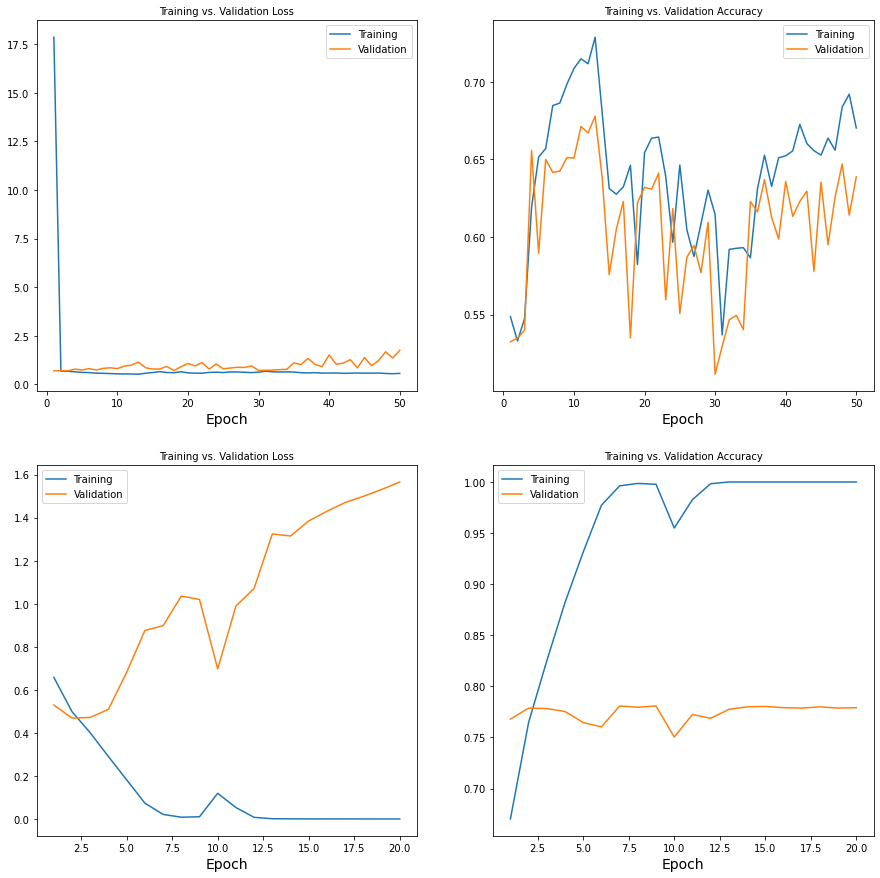

In [495]:
plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)

plt.plot(np.arange(1, 51), history.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history.history['val_loss'], label='Validation')
plt.title('Training vs. Validation Loss', size=10)
plt.xlabel('Epoch', size=14)
plt.legend()


plt.subplot(2, 2, 2)

plt.plot(np.arange(1, 51), history.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history.history['val_accuracy'], label='Validation')
plt.title('Training vs. Validation Accuracy', size=10)
plt.xlabel('Epoch', size=14)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(np.arange(1, 21), history_cnn.history['loss'], label='Training')
plt.plot(np.arange(1, 21), history_cnn.history['val_loss'], label='Validation')
plt.title('Training vs. Validation Loss', size=10)
plt.xlabel('Epoch', size=14)
plt.legend()


plt.subplot(2, 2, 4)

plt.plot(np.arange(1, 21), history_cnn.history['accuracy'], label='Training')
plt.plot(np.arange(1, 21), history_cnn.history['val_accuracy'], label='Validation')
plt.title('Training vs. Validation Accuracy', size=10)
plt.xlabel('Epoch', size=14)
plt.legend()

plt.show()

**Konvoluciona mreža** prividno izgleda kao najbolja jer kaže da smo dobili predikciju od 100% tokom treninga, ali validacioni set kaže da je model samo overfitovan i da što duže traje trening, to gore performanse imamo na validacionom setu. Što je manji gubitak tokom treninga mreže trening setom, to je veći gubitak na validacionom setu, uprkos tome što je tačnost na validacionom setu sa malim oscilacijama i sa pristojnom preciznošću.
Uz prepravke, trebalo bi da konvoluciona mreža zaista bude najbolji model.
Isprobana je verzija sa **ImageDataGenerator** bibliotekom zbog sprečavanja preprilagodjavanja, ali uz greške koje nisu uspele da budu rešene. 

**Neuralna mreža** nam kaže da smo već kod trinaeste epohe imali najbolje rezultate u kontekstu tačnosti i gubitka, ali sa tačnošću oko 72,87%. 